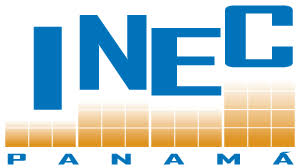

# Libreria Auxiliar

In [1]:
import pykalman as kalman
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import os

from ipynb.fs.defs.ConstruccionBasedeDatos import BasedeDatos

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm


import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

###  Filtro de Kalman

In [59]:
def kalman_fed_nyc(bd_all, X, y, n_factors, params,initial_state_mean,initial_state_covariance, test_size):
    import numpy as numpy
    from pykalman import KalmanFilter

    n_vars = len(y + X)
    
    ##############################################################################
    #Data
    
    bd = bd_all[y + X]
    size_drop = int(bd.shape[0]/3)
    
    bd = bd.drop(bd.index[
                        (bd.index < bd.index[size_drop]) * 
                        (bd.isna().any(axis = 1).values)
                        ])
    
    #Fijando base de referencia  en caso se haga un ejercicio de train test
    bd_data = bd[y]
    
    
    #No se recibe informacion test_size periodos
    if test_size>0:
        bd.loc[-test_size:,y] = np.nan
    
    ###############################################################################
    #Demean data

    mean = bd.mean()
    
    bd_demean = pd.DataFrame()
    
    for i in bd.columns:
        bd_demean[i] =  bd[i] - mean[i]
        
    
    ################################################################################
    #Llenando data faltante

    bd_demean = bd_demean.fillna(0)

    #Parametros
    phi   = params[0]
    var_m = params[1]
    rho   = params[2]
    var_e = params[3]
    beta  = params[4]

    ###############################################
    #Matriz de observables

    H = []

    for date in bd_demean.index:
        aux = np.zeros([n_vars,n_factors+n_vars])
        i_aux = np.eye(n_vars)
        for i_var,var in enumerate(bd_demean.columns):
            if (bd_demean.loc[date,var] != 0):
                aux[i_var,:] = np.array(list(beta[i_var,:]) + list(i_aux[i_var,:]))
        H.append(aux)



    observation_offset = [0] * n_vars
    observation_matrix = np.array(H)
    observation_covariance =  np.zeros([n_vars,n_vars])

    H_ = np.zeros([n_vars,n_factors+n_vars])
    H_[:,:n_factors] = beta
    H_[:,n_factors:] = np.eye(n_vars)
    
    ###############################################
    #Transicion

    #Interceptos
    transition_offset = [0] * (n_factors + n_vars)

    #Matriz de transicion
    transition_matrix = np.zeros([n_factors + n_vars,n_factors + n_vars])
    transition_matrix[:n_factors,:n_factors] = np.diag(phi)
    transition_matrix[n_factors:,n_factors:] = np.diag(rho)

    #Varianzas 

    transition_covariance = np.zeros([n_factors + n_vars,n_factors + n_vars])
    transition_covariance[:n_factors,:n_factors] = np.diag(var_m)
    transition_covariance[n_factors:,n_factors:] = np.diag(var_e)

    ###############################################
    #Estados iniciales
    initial_state_mean = np.zeros([n_factors + n_vars])
    initial_state_covariance = np.eye(n_factors + n_vars) * 0.01**2

    # Creando filtro
    kf = KalmanFilter(
        transition_matrix, observation_matrix, 
        transition_covariance, observation_covariance,
        transition_offset,observation_offset,
        initial_state_mean, initial_state_covariance
        ,random_state=1109
    )

    ll = kf.loglikelihood(bd_demean)

    bd_S = pd.DataFrame(kf.smooth(bd_demean[y + X])[0], index = bd_demean.index).rename(columns = lambda y: 'NoObservale_Suavizada_' + str(y))
    bd_F = pd.DataFrame(kf.filter(bd_demean[y + X])[0], index = bd_demean.index).rename(columns = lambda y: 'NoObservale_Filtrada_' + str(y))
    bd_P = pd.DataFrame(kf.filter(bd_demean[y + X])[0] @ np.transpose(H_),index = bd_demean.index, columns = bd_demean.columns)
    
    
    for i in bd_P.columns:
        bd_P[i] = bd_P + mean[i]
    
    
    return ll, kf, bd_S, bd_F, bd_P, bd, bd_data


def t_params(h_params,n_vars,n_factors):
    
    phi = []
    for x in h_params[0:n_factors]:
        phi.append(x/(1+abs(x)))
    
    var_m = []
    for x in h_params[n_factors:2*n_factors]:
        var_m.append(x**2)
    
    
    rho = []
    for x in h_params[2*n_factors:2*n_factors+n_vars]:
        rho.append(x/(1+abs(x)))
    
    
    var_e = []
    for x in h_params[2*n_factors+n_vars:2*n_factors+2*n_vars]:
        var_e.append(x**2)
    
    
    beta = np.array(h_params[2*n_factors+2*n_vars:]).reshape(n_vars,n_factors)
    
    params = [phi,var_m,rho,var_e,beta]
    
    return params

def t_inv_param(params):
    phi = params[0]
    var_m = params[1]
    rho = params[2]
    var_e = params[3]
    beta = params[4]
    
    
    h_params = []
    
    for x in phi:
        h_params.append(x/(1-x))
    
    
    for x in var_m:
        h_params.append(x**0.5)
    
    
    for x in rho:
        h_params.append(x/(1-x))
    
    
    for x in var_e:
        h_params.append(x**0.5)
    
    
    
    h_params = h_params + list(beta.flat[:])

    return h_params

def set_init_params(bd_all, X, y, n_factors,test_size):
    from sklearn.decomposition import PCA
    from sklearn.linear_model import LinearRegression

    n_vars = len(y + X)
    
    
    bd = bd_all[y + X]
    bd = bd.dropna()
    
    #############################################################
    #Componentes Principales
    #############################################################
    
    PCA_IC = PCA(n_components=n_factors)
    lin_reg = LinearRegression(fit_intercept = False)
    
    PC_IC = PCA_IC.fit_transform(bd)
    
    
    #Beta
    beta_ic = np.transpose(PCA_IC.components_)

    
    #Phi y sigma_m
    phi_ic = []
    var_m_ic = []


    for j in range(n_factors):

        lin_reg.fit(PC_IC[:-1,j].reshape(-1,1),PC_IC[1:,j].reshape(-1,1))
        phi_ic.append(lin_reg.coef_[0,0])
        var_m_ic.append(np.var(PC_IC[:,j])*(1-lin_reg.coef_[0,0]**2))

    
    #Errores de prediccion
    
    rho_ic = []
    var_e_ic = []
    
    error = bd.values - PCA_IC.inverse_transform(PC_IC)
    
    for j in range(n_vars):
        lin_reg.fit(error[:-1,j].reshape(-1,1),error[1:,j].reshape(-1,1))
        rho_ic.append(lin_reg.coef_[0,0])
        var_e_ic.append(np.var(error[:-1,j])*(1-lin_reg.coef_[0,0]**2))
    
    
    initial_state_mean = PC_IC[0,:]
    initial_state_covariance = np.diag(np.var(PC_IC,axis=0))
    
    params_ic = [phi_ic,var_m_ic,rho_ic,var_e_ic,beta_ic]
        
    h_params_ic =t_inv_param(params_ic)
    
    return params_ic, h_params_ic, initial_state_mean, initial_state_covariance